In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import matplotlib.pyplot as plt
import numpy as np

from reflectolearn.processing.fitting import (
    estimate_q,
    func_gauss,
    func_gauss3_with_noise,
    func_noise,
    s_vector_transform_q,
    tth2qz_by_energy,
    xrr_fft,
)
from reflectolearn.processing.preprocess import remove_q4_decay
from reflectolearn.processing.simulate import make_n_layer_structure, make_parameters, structure_to_R

In [150]:
from scipy.optimize import curve_fit

from reflectolearn.math_utils import apply_poisson_noise, get_background_noise


def multi_gaussian_fitting(x_fit, y_fit, p0):
    bounds = (0, np.inf)
    popt, pcov = curve_fit(func_gauss3_with_noise, x_fit, y_fit, p0=p0, bounds=bounds)

    return popt, pcov


def add_noise(R):
    N = len(R)
    R_poisson = apply_poisson_noise(R, s=10 ** 9)
    uniform_noise = 1 + np.random.uniform(-0.01, 0.01, N)
    background_noise = get_background_noise(N, -8, -7)
    curve_scaling = np.random.uniform(0.99, 1.01)
    return R_poisson * uniform_noise * curve_scaling + background_noise


thicknesses = [37.90662454173169, 76.20298441858712]
roughnesses = [0.6840129640172916, 1.6441365385880196]
slds = [1.6448820799183554, 1.1180994749737252]
real_thick_combs = [37.90662454173169, 114.10960896031881, 76.20298441858712]


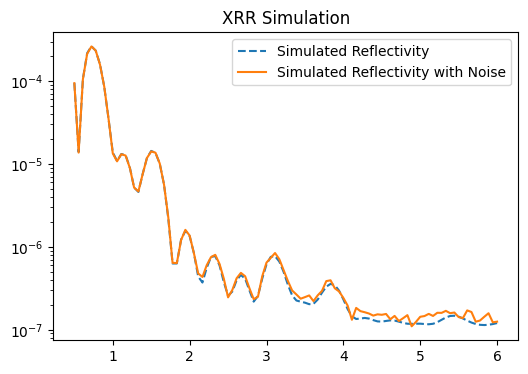

In [151]:
from itertools import combinations_with_replacement

# -----------------------
# 1. 데이터 생성
# -----------------------
beam_energy = 8.04751  # keV
tth = np.linspace(0.5, 6, 100)  # rad
q = tth2qz_by_energy(tth, beam_energy)

# 2층 박막 시뮬레이션 (기판 + 2개 필름)
thicknesses, roughnesses, slds = make_parameters(2)

structure = make_n_layer_structure(thicknesses, roughnesses, slds)
print(f"{thicknesses = }")
print(f"{roughnesses = }")
print(f"{slds = }")

real_thicks = thicknesses
real_thick_combs = [sum(set(comb)) for comb in combinations_with_replacement(real_thicks, r=len(real_thicks))]
print(f"{real_thick_combs = }")
R = structure_to_R(structure, q)
R_noise = R.copy()
R_noise = add_noise(R)

# Plot
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.semilogy(tth, R, "--", label="Simulated Reflectivity")
axs.semilogy(tth, R_noise, "-", label="Simulated Reflectivity with Noise")

axs.set_title("XRR Simulation")
axs.legend()
plt.show()

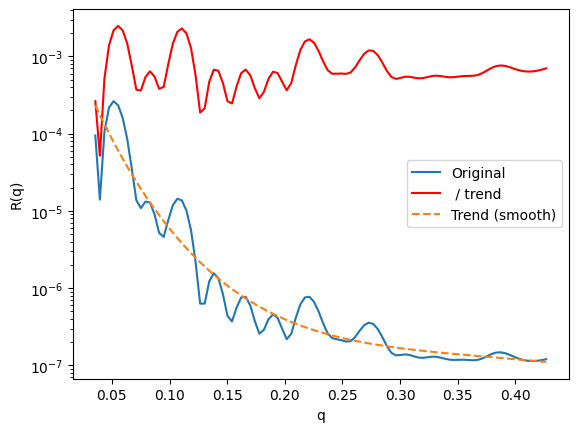

In [152]:
from scipy.signal import savgol_filter


def normalize_by_R(arr, R):
    if R.max() == 0:
        return arr
    return arr / arr[0] * R.max()

# 1. 부드러운 트렌드 생성
R_smooth = savgol_filter(np.log10(R), window_length=int(len(R)), polyorder=4, mode='interp')
trend = 10**R_smooth

# 2. 평탄화
R_flat = R / trend
R_flat = normalize_by_R(R_flat, R)
# 시각화
plt.figure()
plt.plot(q, R, label='Original')
plt.plot(q, R_flat, label=' / trend', color='red')
plt.plot(q, trend, label='Trend (smooth)', linestyle='--')
plt.xlabel('q')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()

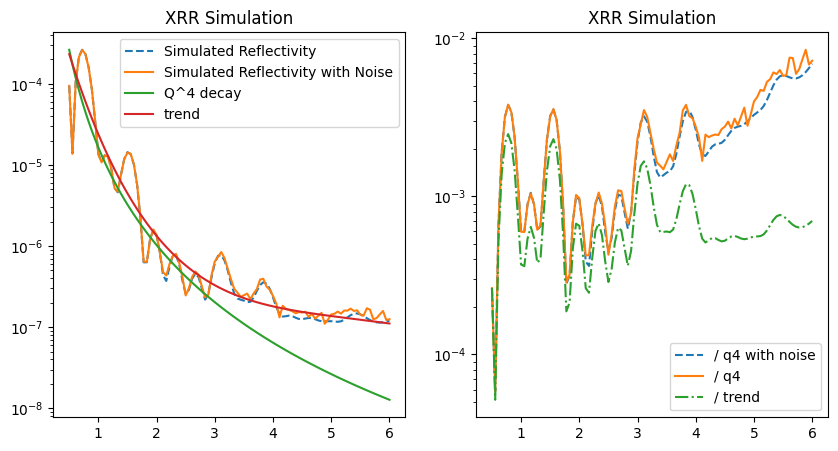

In [153]:
R_no_q_decay = remove_q4_decay(q, R)
R_noise_no_q_decay = remove_q4_decay(q, R_noise)
R_no_q_decay = normalize_by_R(R_no_q_decay, R)
R_noise_no_q_decay = normalize_by_R(R_noise_no_q_decay, R)


decay = 1 / remove_q4_decay(q, np.full_like(q, 1))
decay = decay / decay[0] * R.max()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].semilogy(tth, R, "--", label="Simulated Reflectivity")
axs[0].semilogy(tth, R_noise, "-", label="Simulated Reflectivity with Noise")
axs[0].semilogy(tth, decay, "-", label="Q^4 decay")
axs[0].semilogy(tth, trend, "-", label="trend")
axs[0].set_title("XRR Simulation")
axs[0].legend()

axs[1].semilogy(tth, R_no_q_decay, "--", label="/ q4 with noise")
axs[1].semilogy(tth, R_noise_no_q_decay, "-", label="/ q4")
axs[1].semilogy(tth, R_flat, "-.", label="/ trend")
axs[1].set_title("XRR Simulation")
axs[1].legend()

plt.show()

In [154]:
from scipy.signal import argrelmax


def find_arg_peaks(arr):
    idx_local_max = argrelmax(arr)
    return idx_local_max

In [155]:
def fft_q4(q, R, window=2, n=10000):
    xproc, yproc = s_vector_transform_q(q, R, 0)
    x_fft, y_fft = xrr_fft(xproc, yproc, window=window, n=n)
    return x_fft, y_fft

def fft_savgol(q, R, window=2, n=10000):
    R_smooth = savgol_filter(np.log10(R), window_length=51, polyorder=3)  # 51점, 3차 다항식
    trend = 10**R_smooth
    R_flat = R / trend
    R_flat = normalize_by_R(R_flat, R)
    x_fft, y_fft = xrr_fft(q, R_flat, window=window, n=n)
    return x_fft, y_fft

def fft(q, R, window=2, n=10000):
    x_fft, y_fft = xrr_fft(q, R, window=window, n=n)
    return x_fft, y_fft

Estimated critical q: 0.0000


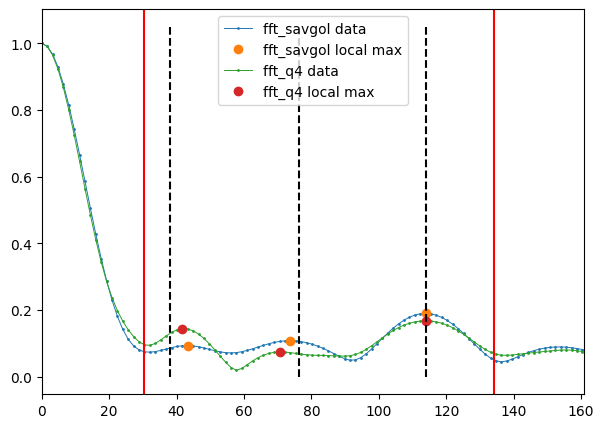

In [156]:
# x_upper_bound = 200
x_upper_bound = sum(real_thicks) + 20
# crit_q = estimate_q(q, R_noise)
crit_q = 0
print(f"Estimated critical q: {crit_q:.4f}")

# FFT
# dat = np.stack([q, R_noise_no_q_decay], axis=1)
# xproc, yproc = s_vector_transform_q(q, R, crit_q)
fig, axs = plt.subplots(1, 1, sharex=True, figsize=(7, 5))

for fft_ in [fft_savgol, fft_q4]:
    x_fft, y_fft = fft_(q, R, window=2, n=10000)
    x_fft = x_fft * 2 * np.pi
    y_fft_norm = y_fft / y_fft.max()

    idx_local_max = find_arg_peaks(y_fft_norm[x_fft < x_upper_bound])
    axs.plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, label=f"{fft_.__name__} data")
    axs.plot(x_fft[idx_local_max], y_fft_norm[idx_local_max], "o", label=f"{fft_.__name__} local max")
# First increasing index
# y_diff = np.diff(y_fft_norm)
# under_bound_index = np.where((y_diff >= -0.01) & (x_fft[1:] > 2))[0][0] + 1
y_diff = np.diff(y_fft_norm)
under_bound_index = np.where((y_diff >= -0.01) & (x_fft[1:] > 2))[0][0] + 1
# d2ydx2 = np.gradient(np.gradient(y_fft_norm, x_fft))
# under_bound_index = np.where(d2ydx2 > 0)[0][0]

# under_bound_index = np.abs(x_fft - crit_q * 2*np.pi).argmin()
x_under_bound = x_fft[under_bound_index]
upper_bound_index = np.where(x_fft > x_upper_bound)[0][0]


idx_real_thick_comb: list[int] = [np.abs(x_fft - thickness).argmin() for thickness in real_thick_combs]
plt.vlines(x=real_thick_combs, ymin=0, ymax=plt.ylim()[1], color='k', linestyle='--')

axs.axvline(x=x_fft[under_bound_index], color='r', linestyle='-')
axs.axvline(x=x_upper_bound, color='r', linestyle='-')
axs.set_xlim(0, x_upper_bound*1.2)
# axs.set_yscale('log')
plt.legend()
plt.show()

(array([   8,    9,   10, ..., 4992, 4998, 4999], shape=(2466,)),)


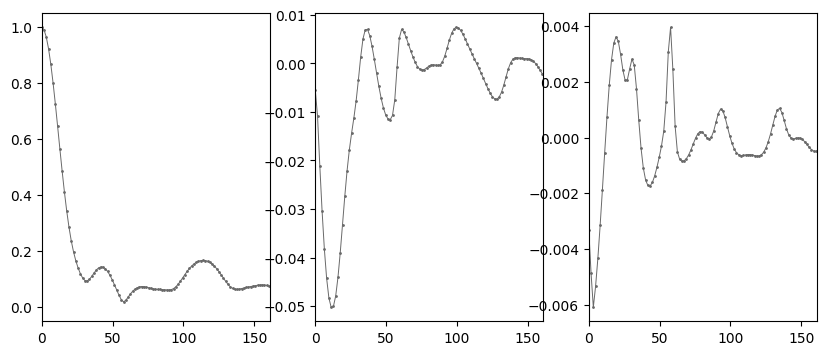

In [157]:
dydx = np.gradient(y_fft_norm, x_fft)
# 2차 도함수 (곡률)
d2ydx2 = np.gradient(dydx, x_fft)

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(10, 4))
axs[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
axs[1].plot(x_fft, dydx, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
axs[2].plot(x_fft, d2ydx2, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")

for ax in axs:
    ax.set_xlim(0, x_upper_bound*1.2)

print(np.where(d2ydx2 > 0))

In [158]:
print(x_fft[under_bound_index], x_fft[upper_bound_index])

# fitting range
# mask = (x_fft < x_upper_bound) & (x_fft > under_bound_index)
# x_fit, y_fit = x_fft[under_bound_index: upper_bound_index + 1], y_fft_norm[under_bound_index: upper_bound_index + 1]
x_fit, y_fit = x_fft, y_fft

# local maxima들의 인덱스와 값
y_local = y_fit[idx_local_max]
x_local = x_fit[idx_local_max]

# 값이 큰 상위 2개 인덱스 추출
top2_indices = np.argsort(y_local)[-2:]          # 상위 2개 (y 값 기준)
top2_x = x_local[top2_indices]                   # 그 두 점의 x 위치

# 왼쪽/오른쪽 순서 정렬
top2_sorted = np.sort(top2_x)

if len(top2_sorted) == 1:
    top2_sorted = np.array([top2_sorted[0]]*2)
# 결과 할당
pmax2, pmax3 = top2_sorted[0], top2_sorted[1]
print(pmax2, pmax3)


params: list[str]= ["a1", "w1", "a2", "pmax2", "w2", "a3", "pmax3", "w3", "amp", "ex", "z0"]
p0: list[float] = [0.1, 5, 0.1, pmax2, 5, 0.1, pmax3, 5, 1, 2, 0.001]
print(f"Initial guess:\n{list(zip(params, p0, strict=True))}")
popt, pcov = multi_gaussian_fitting(x_fit, y_fit, p0)

pos2 = popt[3]
pos3 = popt[6]
pos1 = pos3-pos2

# ----------------------- Report -----------------------
print(">>> Multi-Gaussian fit results")
print(f"- G1: amp={popt[0]:.2f}, pos≈{pos1:.2f} Å, w={popt[1]:.2f}")
print(f"- G2: amp={popt[2]:.2f}, pos≈{pos2:.2f} Å, w={popt[4]:.2f}")
print(f"- G3: amp={popt[5]:.2f}, pos≈{pos3:.2f} Å, w={popt[7]:.2f}")
print(f"- Noise: amp={popt[8]:.2e}, exp={popt[9]:.2f}, offset={popt[10]:.2e}")

# ----------------------- Plot -----------------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

# (상단: 전체 fit vs 데이터)
axs[0].plot(x_fit, func_gauss3_with_noise(x_fit, *popt), "-", color="goldenrod", lw=2, label="multi-Gaussian fit")
axs[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, label="FFT data")
axs[0].axvline(x=x_under_bound, color='r', linestyle='--')
axs[0].axvline(x=x_upper_bound, color='r', linestyle='--')
axs[0].plot(x_local[top2_indices], y_local[top2_indices]  , "o", color="red", label="top 2 local max")
axs[0].plot(x_fft[idx_real_thick_comb], y_fft_norm[idx_real_thick_comb], "x", color="b", label="Real thickness")
axs[0].set_ylabel("Normalized FFT amplitude")
axs[0].legend()

# (하단: component 분리 보기)
axs[1].plot(x_fit, func_gauss(x_fit, *popt[2:5]), "--", color="red", label="Gaussian 1")
axs[1].plot(x_fit, func_gauss(x_fit, popt[0], popt[6] - popt[3], popt[1]), "--", color="blue", label="Gaussian 2")
axs[1].plot(x_fit, func_gauss(x_fit, *popt[5:8]), "--", color="gray", label="Gaussian 3")
axs[1].plot(x_fit, func_noise(x_fit, *popt[8:10]), "--", label="1/f^alpha")
axs[1].plot(x_fit, np.ones_like(x_fit)*popt[10], ":", label="offset")
axs[1].plot(x_fft, y_fft_norm, "-", color='k', ms=1, lw=0.7, label="FFT data")
axs[1].axvline(x=x_under_bound, color='r', linestyle='--')
axs[1].axvline(x=x_upper_bound, color='r', linestyle='--')
positions = [pos1, pos2, pos3]
idxs = [np.argmin(np.abs(x_fit - pos)) for pos in positions]
for i, idx in enumerate(idxs, start=1):
    axs[1].plot(x_fit[idx], y_fit[idx], "s", label=f"pos{i} ({x_fit[idx]})")

axs[1].set_xlabel("Thickness [Å]")
axs[1].set_ylabel("Components")
axs[1].legend()

axs[0].set_xlim(0, x_upper_bound*1.2)
axs[1].set_xlim(0, x_upper_bound*1.2)
axs[0].set_ylim(0, 1.0)
axs[1].set_ylim(0, 1.0)

fig.subplots_adjust(hspace=0.3)
plt.show()

30.478966084941487 134.74911321763605
41.70805885307782 113.89508379109714
Initial guess:
[('a1', 0.1), ('w1', 5), ('a2', 0.1), ('pmax2', np.float64(41.70805885307782)), ('w2', 5), ('a3', 0.1), ('pmax3', np.float64(113.89508379109714)), ('w3', 5), ('amp', 1), ('ex', 2), ('z0', 0.001)]


ValueError: Residuals are not finite in the initial point.

In [ ]:
from reflectolearn.processing.fitting import (
    func_gauss3_with_noise_ver2,
    func_noise2,
)


def multi_gaussian_fitting2(x_fit, y_fit, p0):
    # ----------------------- Fit -----------------------
    bounds = (0, np.inf)
    popt, pcov = curve_fit(func_gauss3_with_noise_ver2, x_fit, y_fit, p0=p0, bounds=bounds)

    return popt, pcov

print(x_fft[under_bound_index], x_fft[upper_bound_index])

# fitting range
# mask = (x_fft < x_upper_bound) & (x_fft > under_bound_index)
x_fit, y_fit = x_fft[under_bound_index: upper_bound_index + 1], y_fft_norm[under_bound_index: upper_bound_index + 1]


# local maxima들의 인덱스와 값
y_local = y_fit[idx_local_max]
x_local = x_fit[idx_local_max]

# 값이 큰 상위 2개 인덱스 추출
top2_indices = np.argsort(y_local)[-2:]          # 상위 2개 (y 값 기준)
top2_x = x_local[top2_indices]                   # 그 두 점의 x 위치

# 왼쪽/오른쪽 순서 정렬
top2_sorted = np.sort(top2_x)

# 결과 할당
if len(top2_sorted) == 1:
    top2_sorted = np.array([top2_sorted[0]]*2)
pmax2, pmax3 = top2_sorted[0], top2_sorted[1]
print(pmax2, pmax3)


params: list[str]= ["a1", "w1", "a2", "pmax2", "w2", "a3", "pmax3", "w3", "a4", "w4", "z0"]
p0: list[float] = [0.1, 5, 0.1, pmax2, 5, 0.1, pmax3, 5, 1, 10, 0.001]
print(f"Initial guess:\n{list(zip(params, p0, strict=True))}")
popt, pcov = multi_gaussian_fitting2(x_fit, y_fit, p0)

pos2 = popt[3]
pos3 = popt[6]
pos1 = pos3-pos2

# ----------------------- Report -----------------------
print(">>> Multi-Gaussian fit results")
print(f"- G1: amp={popt[0]:.2f}, pos≈{pos1:.2f} Å, w={popt[1]:.2f}")
print(f"- G2: amp={popt[2]:.2f}, pos≈{pos2:.2f} Å, w={popt[4]:.2f}")
print(f"- G3: amp={popt[5]:.2f}, pos≈{pos3:.2f} Å, w={popt[7]:.2f}")
print(f"- Noise: amp={popt[8]:.2e}, exp={popt[9]:.2f}, offset={popt[10]:.2e}")

# ----------------------- Plot -----------------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

# (상단: 전체 fit vs 데이터)
axs[0].plot(x_fit, func_gauss3_with_noise_ver2(x_fit, *popt), "-", color="goldenrod", lw=2, label="multi-Gaussian fit")
axs[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, label="FFT data")
axs[0].axvline(x=x_under_bound, color='r', linestyle='--')
axs[0].axvline(x=x_upper_bound, color='r', linestyle='--')
axs[0].plot(x_local[top2_indices], y_local[top2_indices]  , "o", color="red", label="top 2 local max")
axs[0].plot(x_fft[idx_real_thick_comb], y_fft_norm[idx_real_thick_comb], "x", color="b", label="Real thickness")
axs[0].set_ylabel("Normalized FFT amplitude")
axs[0].legend()

# (하단: component 분리 보기)
axs[1].plot(x_fit, func_gauss(x_fit, *popt[2:5]), "--", color="red", label="Gaussian 1")
axs[1].plot(x_fit, func_gauss(x_fit, popt[0], popt[6] - popt[3], popt[1]), "--", color="blue", label="Gaussian 2")
axs[1].plot(x_fit, func_gauss(x_fit, *popt[5:8]), "--", color="gray", label="Gaussian 3")
axs[1].plot(x_fit, func_noise2(x_fit, *popt[8:10]), "--", label="gaussian noise")
axs[1].plot(x_fit, np.ones_like(x_fit)*popt[10], ":", label="offset")
axs[1].plot(x_fft, y_fft_norm, "-", color='k', ms=1, lw=0.7, label="FFT data")
axs[1].axvline(x=x_under_bound, color='r', linestyle='--')
axs[1].axvline(x=x_upper_bound, color='r', linestyle='--')
positions = [pos1, pos2, pos3]
idxs = [np.argmin(np.abs(x_fit - pos)) for pos in positions]
for i, idx in enumerate(idxs, start=1):
    axs[1].plot(x_fit[idx], y_fit[idx], "s", label=f"pos{i} ({x_fit[idx]})")

axs[1].set_xlabel("Thickness [Å]")
axs[1].set_ylabel("Components")
axs[1].legend()

axs[0].set_xlim(0, x_upper_bound*1.2)
axs[1].set_xlim(0, x_upper_bound*1.2)
axs[0].set_ylim(0, 1.0)
axs[1].set_ylim(0, 1.0)

fig.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
sorted_real_thicks = sorted(real_thicks)

print(*sorted_real_thicks, sep=", ")
poses = [pos1, pos2, pos3]
poses.sort()
print(*poses[:-1], sep=", ")
print(poses[0] + poses[1], poses[2], sorted_real_thicks[0] + sorted_real_thicks[1])